In [1]:
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sn

In [2]:
idx = pd.read_csv('Excel/profiles.csv')
idx = idx[~idx.NPWP.isna()]
idx = idx[~idx.NPKP.isna()]
idx = idx[~idx.Website.isna()]

idx['length'] = idx['ticker'].str.len()
idx = idx[idx['length'] <6].reset_index(drop = True)
dummy = ['JK']*len(idx)
stock_idx = list(idx['ticker'].str.cat(dummy, sep = '.'))

In [3]:
# data = yf.Tickers(stock_idx)
# stock = []
# remove = []
# count = 0
# for i in stock_idx: 
#     count += 1
#     print(f'Progress : {count}/{len(stock_idx)}')
#     try :
#         if (data.tickers[i].info['priceToBook'] <= 2) & (data.tickers[i].info['returnOnEquity'] > 0.15):
#             stock.append(i)
#     except:
#         remove.append(i)

In [4]:
# df = pd.DataFrame(columns=stock)
# try :
#        df.drop(['ARMY.JK','APLN.JK', 'ARTI.JK','BUVA.JK', 'CINT.JK', 'CPRI.JK', 'DPUM.JK', 'ENVY.JK', 'FORZ.JK',
#               'HOME.JK', 'IBFN.JK', 'JSPT.JK','KPAS.JK', 'LCGP.JK', 'MAGP.JK', 'MIRA.JK', 'RMBA.JK', 'SMRU.JK',], axis = 1, inplace = True)
# except: 
#        pass
# df

In [5]:
# stock = ['ADMF.JK',
#  'AKPI.JK',
#  'ALDO.JK',
#  'AMFG.JK',
#  'ASII.JK',
#  'BBCA.JK',
#  'BISI.JK',
#  'BJBR.JK',
#  'CEKA.JK',
#  'DIVA.JK',
#  'EMDE.JK',
#  'ERAA.JK',
#  'FAPA.JK',
#  'GOOD.JK',
#  'HRTA.JK',
#  'IGAR.JK',
#  'LTLS.JK',
#  'MDLN.JK',
#  'MFIN.JK',
#  'MLIA.JK',
#  'MNCN.JK',
#  'NICK.JK',
#  'PALM.JK',
#  'PANS.JK',
#  'PBID.JK',
#  'PBSA.JK',
#  'PNGO.JK',
#  'PPGL.JK',
#  'PTPW.JK',
#  'SCMA.JK',
#  'SGRO.JK',
#  'SMAR.JK',
#  'SMKL.JK',
#  'SOSS.JK',
#  'SPMA.JK',
#  'SRTG.JK',
#  'TEBE.JK',
#  'TINS.JK',
#  'TRJA.JK',
#  'TURI.JK',
#  'UNTR.JK',
#  'WMUU.JK',
#  'WOOD.JK']

In [18]:
year = 2022
stock = stock_idx
df = pd.DataFrame(columns=stock)
ds = str(year-1)+'-12-01'
for i in stock :
    temp = yf.Ticker(i).history(period = '1y', start = ds, interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return
curr_ = df.describe().T
curr_['count-0'] = df[df ==0].sum()
curr_ = curr_[curr_['mean']>0]
curr_ = curr_[curr_['count-0'] == 0]
curr_ = curr_[curr_['50%'] > 0]
curr_ = curr_[curr_['min'] > -0.1]
curr_stock = set(curr_.index)
curr_stock

{'CLPI.JK', 'IPCM.JK', 'NRCA.JK', 'TSPC.JK', 'ULTJ.JK'}

In [19]:
stock = curr_stock
year = 2023
ds = str(year-2)+'-12-01'
de = str(year+1)+'-12-01'
df = pd.DataFrame(columns=list(stock))
for i in stock :
    temp = yf.Ticker(i).history(start = ds ,end =de ,interval = '1mo',actions=False).dropna()[['Close']]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return
df.dropna(axis = 1, inplace = True)

In [20]:
temp_ = df.describe().T
temp_['count-0'] = df[df ==0].sum()
temp_ = temp_[temp_['mean']>0]
temp_ = temp_[temp_['50%'] > 0]
temp_ = temp_[temp_['min'] > -0.1]
temp_

,count,mean,std,min,25%,50%,75%,max,count-0
NRCA.JK,31.0,0.013660,0.065175,-0.089612,-0.022658,0.007326,0.036419,0.202909,0.0
ULTJ.JK,31.0,0.007306,0.066727,-0.089268,-0.041316,0.006896,0.032881,0.216135,0.0
TSPC.JK,31.0,0.016030,0.045045,-0.080503,-0.007299,0.005540,0.031990,0.120504,0.0
IPCM.JK,31.0,0.004085,0.046787,-0.087598,-0.017954,0.006000,0.024625,0.135341,0.0


In [21]:
# try :
#     df.drop(['TURI.JK'], axis = 1, inplace = True)
# except:
#     pass

In [22]:
mu = df.mean().values
C = df.cov().values

def objective(weights): 
    weights = np.array(weights)
    return weights.dot(C).dot(weights.T)

# The constraints
cons = (
    {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
    #{"type": "ineq", "fun": lambda x: np.sum(mu*x)-0.03}
        )

bounds = tuple((0,1) for x in range(mu.shape[0]))
guess = [1./mu.shape[0] for x in range(mu.shape[0])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
x_ = np.round(optimized_results.x,4)

In [23]:
port_ = dict(zip(df.columns,np.round(x_,5)))
port = dict()
for (key,value) in port_.items():
    if value >0 : 
        port[key] = value
port_df = pd.DataFrame(port_, index = ['Percentage'])
port_df

,NRCA.JK,ULTJ.JK,CLPI.JK,TSPC.JK,IPCM.JK
Percentage,0.1395,0.0525,0.313,0.2262,0.2688


In [29]:
start = 3e6 
budget_ = dict()
for (key,value) in port.items():
    if value >0 : 
        budget_[key] = value*start
budget_

{'NRCA.JK': 418500.00000000006,
 'ULTJ.JK': 157500.0,
 'CLPI.JK': 939000.0,
 'TSPC.JK': 678600.0,
 'IPCM.JK': 806400.0}

In [30]:
budget = pd.DataFrame.from_dict(data= budget_, orient= 'index').T
budget.rename(index={0: 'Total Spread'}, inplace= True)
budget

,NRCA.JK,ULTJ.JK,CLPI.JK,TSPC.JK,IPCM.JK
Total Spread,418500.0,157500.0,939000.0,678600.0,806400.0


In [31]:
expense = pd.DataFrame(columns=port.keys())
for item in port.keys(): 
    temp = yf.Ticker(item).history(period = '1d', interval = '1mo',actions=False)
    expense[item] = temp['Close']*100 #1 lot
expense.rename(index={expense.index[0]: str('Closing ' + str(expense.index[0]).split(' ')[0])}, inplace= True)
expense

,NRCA.JK,ULTJ.JK,CLPI.JK,TSPC.JK,IPCM.JK
Date,,,,,
Closing 2024-07-10,34200.0,186500.0,110000.0,202000.0,26600.0


In [32]:
qty = pd.concat([expense,budget])
temp_ = pd.DataFrame(np.round(qty.iloc[1] / qty.iloc[0],0)).T
temp_.rename(index={0: 'Total Lot'}, inplace= True)
qty = pd.concat([qty, temp_])
spend = pd.DataFrame(np.round(qty.iloc[2] * qty.iloc[0],0)).T
finale = pd.concat([qty, spend])
finale.rename(index={0: 'Total Spending'}, inplace= True)
finale = pd.concat([finale, port_df[finale.columns]])
finale

,NRCA.JK,ULTJ.JK,CLPI.JK,TSPC.JK,IPCM.JK
Closing 2024-07-10,34200.0000,186500.0000,110000.000,202000.0000,26600.0000
Total Spread,418500.0000,157500.0000,939000.000,678600.0000,806400.0000
Total Lot,12.0000,1.0000,9.000,3.0000,30.0000
Total Spending,410400.0000,186500.0000,990000.000,606000.0000,798000.0000
Percentage,0.1395,0.0525,0.313,0.2262,0.2688


In [33]:
# finale.to_excel('Least Risk with Adjustment.xlsx', index = True)
# finale.to_csv('Least Risk with Adjustment.csv', index = True)

In [34]:
finale.sum(axis = 1)

Closing 2024-07-10     559300.0
Total Spread          3000000.0
Total Lot                  55.0
Total Spending        2990900.0
Percentage                  1.0
dtype: float64

In [35]:
finale.columns

Index(['NRCA.JK', 'ULTJ.JK', 'CLPI.JK', 'TSPC.JK', 'IPCM.JK'], dtype='object')

In [36]:
print(f'return :', x_.dot(mu)*100, '%')
print(f'risk :', x_.dot(C).dot(x_)*100, '%')
print(f'Total Money :',finale.sum(axis=1)[-1])
print(f'Total Idle Money :', start - finale.sum(axis=1)[-1])

return : 1.006686672298437 %
risk : 0.0638843326187398 %
Total Money : 1.0
Total Idle Money : 2999999.0


/tmp/ipykernel_28723/2636873254.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Total Money :',finale.sum(axis=1)[-1])
/tmp/ipykernel_28723/2636873254.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Total Idle Money :', start - finale.sum(axis=1)[-1])


In [42]:
test = pd.DataFrame(columns = finale.columns)
for i in finale.columns :
    temp = yf.Ticker(i).history(period = '2y', start = '2022-12-31', interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    test[i] = log_return

In [43]:
ports = [x_[i] for i in range(len(x_)) if x_[i]>0]
ports

[0.1395, 0.0525, 0.313, 0.2262, 0.2688]

In [44]:
test['total_return'] = test.dot(ports)
test

,NRCA.JK,ULTJ.JK,CLPI.JK,TSPC.JK,IPCM.JK,total_return
Date,,,,,,
2023-02-01 00:00:00+07:00,-0.055399,0.036732,0.021053,-0.010734,0.014599,0.002286
2023-03-01 00:00:00+07:00,-0.025643,-0.078405,-0.015748,0.010734,-0.021979,-0.016103
2023-04-01 00:00:00+07:00,-0.006515,0.017575,-0.016000,-0.003565,0.007380,-0.003817
2023-05-01 00:00:00+07:00,0.134348,0.093090,0.057457,0.038534,0.050190,0.063820
2023-06-01 00:00:00+07:00,-0.089612,0.216135,0.039806,0.119690,0.027588,0.045795
2023-07-01 00:00:00+07:00,0.202909,-0.015464,-0.039806,0.100126,-0.013699,0.034001
2023-08-01 00:00:00+07:00,0.005764,-0.043376,0.056353,0.060104,0.061376,0.046258
2023-09-01 00:00:00+07:00,0.022728,-0.089268,-0.020619,0.005540,-0.013889,-0.010450
2023-10-01 00:00:00+07:00,-0.081917,0.011976,0.025708,-0.080503,-0.021202,-0.026661


In [45]:
print(f'Mean return : {test.total_return.mean()*100}%')

Mean return : 1.5242452217733298%


In [50]:
test.describe()

,NRCA.JK,ULTJ.JK,CLPI.JK,TSPC.JK,IPCM.JK,total_return
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,0.012310,0.014435,0.019431,0.025889,0.003085,0.015242
std,0.075870,0.084233,0.041361,0.056337,0.025234,0.027064
min,-0.089612,-0.089268,-0.039806,-0.080503,-0.022473,-0.026661
25%,-0.025643,-0.043376,0.000000,-0.003565,-0.014493,-0.003817
50%,0.005764,0.011976,0.014742,0.010734,-0.007168,0.007439
75%,0.022728,0.036732,0.039806,0.060104,0.014599,0.034001
max,0.202909,0.216135,0.139356,0.120504,0.061376,0.063820


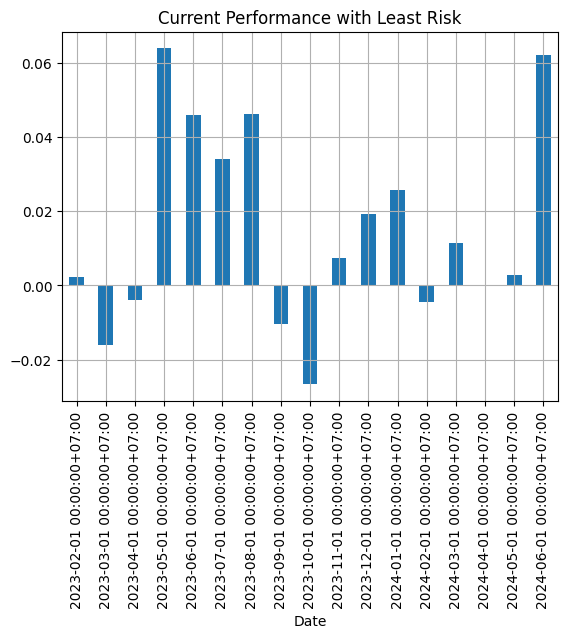

In [46]:
test.total_return.plot.bar()
plt.grid(True)
plt.title('Current Performance with Least Risk')
plt.show()